Implement a Sentiment analysis tool using Python on a public training data (from Kaggle) in any language. Evaluate and show the results.

In [1]:
#-----------------------------------------#
#         IMPORTING LIBRARIES             #
#-----------------------------------------#

import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords

# TensorFlow for Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import warnings
import datetime

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs Available: {len(gpus)}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU..")
else:
    print("GPUs not available, please enable one..")



warnings.filterwarnings('ignore')

GPUs not available, please enable one..


In [3]:
#-----------------------------------------#
#             LOADING DATASET             #
#-----------------------------------------#
df = pd.read_csv("IMDB Dataset.csv")
# Display the first few rows
df.head()

# Check dataset size
print(f"Dataset shape: {df.shape}")

# Check class distribution
print(df['sentiment'].value_counts())

# Convert 'sentiment' column to numeric labels (0 = negative, 1 = positive)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})


Dataset shape: (50000, 2)
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [4]:
#-----------------------------------------#
#             FILTERING TEXT              #
#-----------------------------------------#

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning to reviews
df['cleaned_review'] = df['review'].apply(clean_text)

# Show cleaned text
df[['review', 'cleaned_review']].head()


[nltk_data] Downloading package stopwords to C:\Users\Geetansh
[nltk_data]     Jangid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [5]:
#-----------------------------------------#
#           KERAS TOKENIZATION            #
#-----------------------------------------#

# Load Keras tokenizer
tokenizer = Tokenizer(num_words=30522, oov_token="<OOV>") # Consider adjusting num_words

# Set maximum sequence length
MAX_LEN = 128  # You can adjust this based on memory constraints

# Tokenization function
def keras_tokenize(texts, max_len=128):
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences

# Apply tokenization
input_ids = keras_tokenize(df['cleaned_review']) # Now only input_ids

# Convert labels to NumPy array
labels = np.array(df['sentiment'])

# Check tokenized output shape
print(f"Input IDs shape: {input_ids.shape}")
#print(f"Attention Masks shape: {attention_masks.shape}") # Removed attention mask print
print(f"Labels shape: {labels.shape}")

Input IDs shape: (50000, 128)
Labels shape: (50000,)


In [7]:
#-----------------------------------------#
#           SPLITTING DATASET             #
#-----------------------------------------#

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    input_ids, labels, df.index,  # Keep track of original indices
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Check the shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")


Training Data Shape: (40000, 128)
Training Labels Shape: (40000,)
Testing Data Shape: (10000, 128)
Testing Labels Shape: (10000,)


In [8]:
#-----------------------------------------#
#         CONVERTING TO TF.DATA           #
#-----------------------------------------#

# Set batch size
BATCH_SIZE = 32

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))  # Validation dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))  # Test dataset (for final evaluation)

# Shuffle, batch, and prefetch for efficiency
train_dataset = (train_dataset
                 .shuffle(buffer_size=len(X_train))
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (val_dataset
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

test_dataset = (test_dataset
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

# Check dataset output
for sample in train_dataset.take(1):
    print(f"Sample Input Shape: {sample[0].shape}, Sample Label Shape: {sample[1].shape}")


Sample Input Shape: (32, 128), Sample Label Shape: (32,)


In [9]:

#-----------------------------------------#
#           MODEL DEFINITION              #
#-----------------------------------------#

# Define model parameters
VOCAB_SIZE = 30522  # Adjust as per your tokenizer's vocab size
EMBEDDING_DIM = 128  # Size of word embeddings
MAX_LEN = 128  # Maximum sequence length
LSTM_UNITS = 32  # Reduced LSTM units

# Define Input Layers
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")

# Embedding Layer (trainable)
embedding = Embedding(input_dim=VOCAB_SIZE + 2, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, trainable=True)(input_ids)

# BiLSTM Layer
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(embedding)

# Fully Connected Layers with L2 Regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification output

# Define Model
model = Model(inputs=input_ids, outputs=output)

# Compile Model
model.compile(
    optimizer=RMSprop(learning_rate=1e-4),  # Changed to RMSprop
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model Summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     3,907,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,952,513 (15.08 MB)

 Trainable params: 3,952,513 (15.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

#-----------------------------------------#
#             MODEL TRAINING              #
#-----------------------------------------#

# Define TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=1, restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6
)

# Train the Model using tf.data dataset
history = model.fit(
    train_dataset,  # Use tf.data pipeline
    validation_data=val_dataset,  # Use tf.data pipeline for validation
    epochs=10,  
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]  # ✅ Added TensorBoard
)



Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.5111 - loss: 1.1122 - val_accuracy: 0.6279 - val_loss: 0.7449 - learning_rate: 1.0000e-04
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.6643 - loss: 0.6855 - val_accuracy: 0.8153 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 106ms/step - accuracy: 0.8004 - loss: 0.4931 - val_accuracy: 0.8492 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 106ms/step - accuracy: 0.8437 - loss: 0.4166 - val_accuracy: 0.8607 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.8635 - loss: 0.3742 - val_accuracy: 0.8630 - val_loss: 0.3417 - learning_rate: 1.0000e-04
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8776 - loss: 0.3437 - val_accuracy: 0.8617 - val_loss: 0.3421 - learning_rate: 1.0000e-04


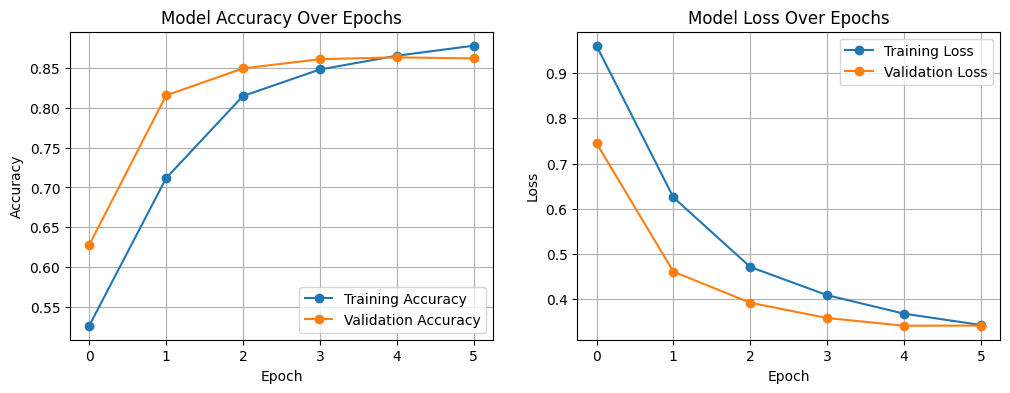

In [11]:
#-----------------------------------------#
#   VISUALIZATION OF TRAINING PROCESS     #
#-----------------------------------------#

# Plot Validation Accuracy vs Training Accuracy and Validation Loss vs Training Loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()


In [24]:
#-----------------------------------------#
#        TENSORBOARD VISUALIZATION        #
#-----------------------------------------#
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13772), started 0:11:08 ago. (Use '!kill 13772' to kill it.)

In [19]:
#-----------------------------------------#
#           MAKING PREDICTIONS            #
#-----------------------------------------#

# Make predictions using the tf.data pipeline
y_pred_probs = model.predict(val_dataset) 

# Ensure predictions are a NumPy array
y_pred_probs = np.array(y_pred_probs)

# Convert probabilities to binary labels
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Fix flattening

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Accuracy: 0.8630
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
 [[4316  684]
 [ 686 4314]]


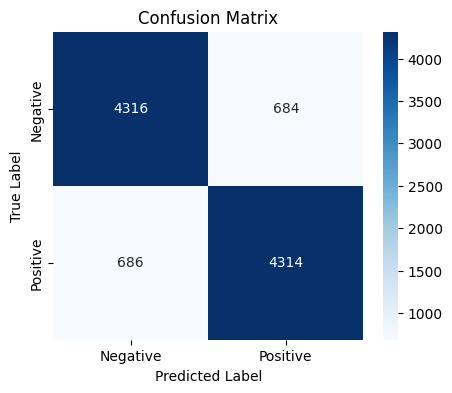

In [20]:
#-----------------------------------------#
#            CONFUSION MATRIX             #
#-----------------------------------------#

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


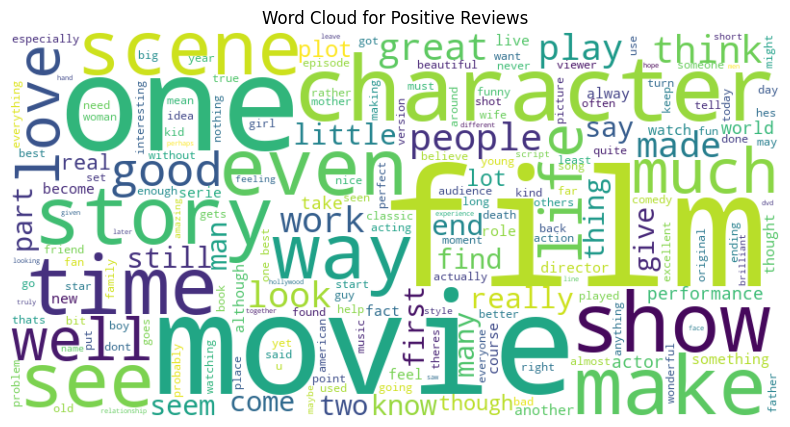

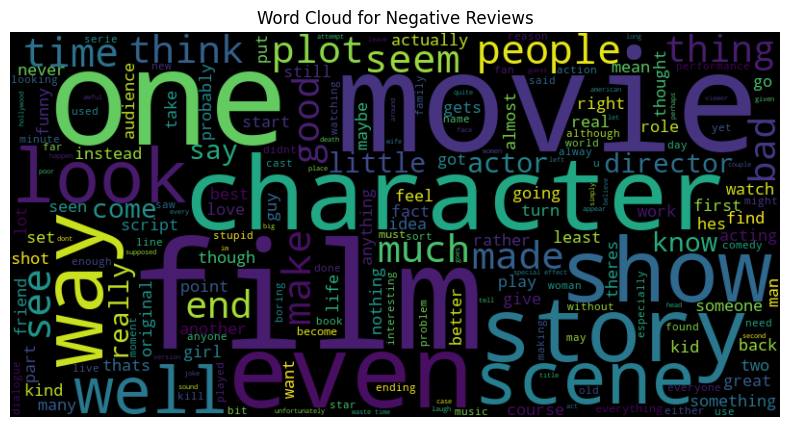

In [21]:
#-----------------------------------------#
#              WORD CLOUDS                #
#-----------------------------------------#

# Separate positive & negative reviews
pos_reviews = df[df["sentiment"] == 1]["cleaned_review"]
neg_reviews = df[df["sentiment"] == 0]["cleaned_review"]

# Generate Word Clouds
pos_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(pos_reviews))
neg_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(neg_reviews))

# Plot Positive Reviews Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

# Plot Negative Reviews Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()


In [22]:
#-----------------------------------------#
#         SHOWCASING PREDICTIONS          #
#-----------------------------------------#

# Create a DataFrame with test reviews and labels
df_test = pd.DataFrame({
    "review": df.loc[test_indices, "review"].values,  # Extract text reviews
    "actual_sentiment": y_test,  # Ground truth labels
    "predicted_sentiment": y_pred  # Model predictions
})

# Convert numerical labels to "Positive" or "Negative"
df_test["actual_sentiment"] = df_test["actual_sentiment"].map({1: "Positive", 0: "Negative"})
df_test["predicted_sentiment"] = df_test["predicted_sentiment"].map({1: "Positive", 0: "Negative"})

# Select 5 random samples from the test set
df_sampled = df_test.sample(5, random_state=42)  # Ensures reproducibility

# Display predictions
for _, row in df_sampled.iterrows():
    print(f"Review: {row['review'][:300]}...")  # Prints first 300 characters
    print(f"Actual Sentiment: {row['actual_sentiment']}")
    print(f"Predicted Sentiment: {row['predicted_sentiment']}")
    print("-" * 80)


Review: This is loosely based on the ideas of the original 80's hit . It's set in the modern day as we see a base in Afghanistan get destroyed by a UAV right at the start.<br /><br />And that's exactly where the movie jumps the shark. UAV's aren't armed. They could be but I don't think it's ever been tried ...
Actual Sentiment: Negative
Predicted Sentiment: Negative
--------------------------------------------------------------------------------
Review: This movie was on British TV last night, and is wonderful! Strong women, great music (most of the time) and just makes you think. We do have stereotypes of what older people "ought" to do, and there are fantastic cameos of the "sensible but worried children". Getting near to my best movie ever !...
Actual Sentiment: Positive
Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Review: What a dreadful movie. The effects were poor, especially by todays standards, but that was forgi

In [23]:
#-----------------------------------------#
#             MODEL SUMMARY               #
#-----------------------------------------#

print("Final Model Performance Summary")
print("=" * 40)
print(f"Accuracy: {accuracy:.4f}")
print("Precision, Recall, F1-Score:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print("=" * 40)


Final Model Performance Summary
Accuracy: 0.8630
Precision, Recall, F1-Score:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
[[4316  684]
 [ 686 4314]]
